In [83]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import torch
torch.manual_seed(8)
import random
random.seed(125)
import torch_f as torch_f
from modelovae import Node, GRASSEncoder, GRASSDecoder, deserialize
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import statistics
from scipy.stats import sem, t

para calcular las metricas tengo que pasar las centerlines generadas a arbol
primero paso el numpy a vtk y a partir del vtk uso el codigo de preprocessing para llegar a arbol
el tema con los arboles separados es que o falla o elije la parte conexa mas grande
revisar esto y sobre todo que cantidad de arboles con problemas de conexion genera
falta generar con intra

In [84]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

In [85]:
def traverseleaves(root, leaves):
    if root is not None:
        traverseleaves(root.left, leaves)
        if root.is_leaf():
            leaves.append(root)
        traverseleaves(root.right, leaves)
        return

def traverse(root):
        if root is not None:
            traverse(root.left)
            root.radius=root.radius.reshape(4)
            traverse(root.right)
            return

def traverseradius(root, rlist):
    if root is not None:
        traverseradius(root.left, rlist)
        rlist.append(root.radius[3])
        print("radius", root.radius[3])
        traverseradius(root.right, rlist)
        return 

def traversefeatures(root, features):
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius[3].cpu().item())
        traversefeatures(root.right, features)
        return features

def traversefeatures2(root, features):
    if root is not None:
        traversefeatures2(root.left, features)
        features.append(root.radius[0][3].cpu().item())
        traversefeatures2(root.right, features)
        return features          

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

@count_fn
def createNode(data, radius,left = None, right = None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, left, right)
 


def read_tree(filename, dir):
    with open('./' +dir +'/' +filename, "r") as f:
        byte = f.read() 
        return byte

def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 

def number_nodes(data_loader, batch_size):
    n_no = []
    qzero = 0
    qOne = 0
    qtwo = 0
    for batch in data_loader:
        for tree in batch:
            tree = tree[0]
            count = []
            n = tree.count_nodes(tree, count)
            n_no.append(len(n))
            li = []
            tree.traverseInorderChilds(tree, li)
            zero = [a for a in li if a == 0]
            one = [a for a in li if a == 1]
            two = [a for a in li if a == 2]
            qzero += len(zero)
            qOne += len(one)
            qtwo += len(two)

    nprom = np.mean(n_no)
    qzero /= len(data_loader)*batch_size
    qOne /= len(data_loader)*batch_size
    qtwo /= len(data_loader)*batch_size
    if round(qzero) == 0:
        qzero = 1
    if round(qOne) == 0:
        qOne = 1
    if round(qtwo) == 0:
        qtwo = 1
    mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
    return mult
    

In [86]:
def decode_testing(v, max, decoder, mult, min):
    def decode_node(v, max, decoder, mult, min):

        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        
        
        if label == 1 and createNode.count <= max:
            right, radius = decoder.internalDecoder(v)
                
            d = createNode(1, radius) 
            
            d.right = decode_node(right, max, decoder, mult, min)
            return d

        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
                
            d = createNode(1, radius)
            
            d.right = decode_node(right, max, decoder, mult, min)
            d.left = decode_node(left, max, decoder, mult, min)
        
            return d

       
        elif label == 0 : ##output del classifier
            radio = decoder.featureDecoder(v)
            return createNode(1,radio)  
        

    createNode.count = 0
    v = decoder.sample_decoder(v)
    dec = decode_node (v, max, decoder, mult, min)

    return dec

In [87]:
def my_collate(batch):
    return batch


class tDataset(Dataset):
    def __init__(self, l, dir, transform=None):
        self.names = l
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file, dir))
        self.trees = []

        for tree in self.data:
            deserial = deserialize(tree)
            self.trees.append(deserial)
            

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        name = self.names[idx]
        return tree

batch_size = 1

In [88]:
dataset_name = "Aneurisk"
p = str(15)
eps = str(0)+str(2)
d = "data/paper/" + dataset_name + "P" +p + "eps" + eps
print("d", d)
t_list = os.listdir(d)[:100]
print(len(t_list))
dataset = tDataset(t_list, d )
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)
    
i = 0
d = None
d_nodos = []
n_bifo = []
for batch in data_loader:
    for input in batch:
        count = []
        numerar_nodos(input, count)
        d_nodos.append(len(count))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bifo.append(len(two))

d data/paper/AneuriskP15eps02
100


In [89]:
def distance(node1, node2):
    """
    Calculates the Euclidean distance between two nodes
    """
    if node1 is not None and node2 is not None:
        dist = ((node1.radius[0]-node2.radius[0])**2 + 
                (node1.radius[1]-node2.radius[1])**2 + 
                (node1.radius[2]-node2.radius[2])**2)**0.5
    else:
        dist = 0
    return dist

def tree_length(node):
    '''calcula el largo total del arbol'''
    if node is None:
        return 0

    stack = [(node, None)]
    length = 0

    while stack:
        curr, prev = stack.pop()

        if curr.left:
            stack.append((curr.left, curr))

        if curr.right:
            stack.append((curr.right, curr))

        if prev:
            length += distance(prev, curr)

    return length

def total_length(root, node, d):
    '''
    calcula la distancia del primer a ultimo nodo, arbol sin bifurcaciones
    '''
    if node.left:
        total_length(root, node.left, d)
    if node.isLeaf():
        #d = distance(root, node)
        d.append(distance(root, node))
        return 
    if node.right:
        total_length(root, node.right, d)

def total_path_length(node):
    """
    Calculates the total path length of the tree
    """
    if node is None:
        return 0
    else:
        return distance(node, node.left) + total_path_length(node.left) + distance(node, node.right) + total_path_length(node.right)

def tortuosity(root):
    """
    Calculates the tortuosity of the tree
    """
    total_path_length_value = total_path_length(root)
    d = []
    max_path_length_value = total_length(root,root, d)
    return total_path_length_value / d[0]

In [90]:
def tr(root):
        if root is not None:
            tr(root.left)
            root.radius[0][3]=root.radius[0][3]/10
            if root.radius[0][3]<0:
                root.radius[0][3]=0
            tr(root.right)
            return

In [91]:
enmax_palette = ["#FE7871", "#B50603"]

color_codes_wanted = ['pink', 'blue']
col = lambda x: enmax_palette[color_codes_wanted.index(x)]

In [92]:
tortuosidad = []
n_bif = []
largo = []
n_nodes = []
ratio_radios = []
for batch in data_loader:
    for input in batch:

        graph = nx.Graph()
        input.toGraph(graph, 0 , False, flag = 0)
        degree1 = []

        for node in graph.nodes():
            if graph.degree(node) == 1:
                degree1.append(node)
       
        caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
    
        subarboles = []
        for g in caminos:
            grafo = nx.Graph()
            grafo.add_nodes_from(g)
            et = []
            for node in grafo.nodes:
                edge = graph[node]
                edges = [a for a in list(edge.keys()) if a in g]
                edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                for tuple in edge_tuple:
                    et.append(tuple)
            grafo.add_edges_from(et)
    
            aRecorrer = []
            numeroNodoInicial = degree1[0]
            r = graph.nodes[numeroNodoInicial]['radio']
            rad = list(graph.nodes[numeroNodoInicial]['posicion'])
            rad.append(r)

            nodoRaiz = Node( numeroNodoInicial, radius =  rad )

            for vecino in grafo.neighbors( numeroNodoInicial ):
                if vecino != numeroNodoInicial:
                    aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
            
            while len(aRecorrer) != 0:
                nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                r = graph.nodes[nodoAAgregar]['radio']
                rad = list(graph.nodes[nodoAAgregar]['posicion'])
                rad.append(r)
                nodoActual = Node( nodoAAgregar, radius =  rad)
                nodoPadre.agregarHijo( nodoActual )
                for vecino in grafo.neighbors( nodoAAgregar ):
                    if vecino != numeroNodoPadre:
                        aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
            subarboles.append(nodoRaiz)
            tortuosidad.append(tortuosity(nodoRaiz))
        li = []
        input.traverseInorderChilds(input, li)
        two = [a for a in li if a == 2]
        n_bif.append(len(two))
        total_path_length_value = tree_length(input)
        largo.append(total_path_length_value.cpu().item())
        count = []
        n = input.countNodes(input, count)
        n_nodes.append(len(n))
        features = []
        traversefeatures(input, features)
        ratio_radios.append(sum(features)/len(features))

In [93]:
i = 0
def calculo_generados(latent_size, Grassdecoder, mult, n=100):
    tortuosidad_generados = []
    n_bif_generados = []
    n_nodes_generados = []
    largo_generados = []
    ratio_radios_generados = []
    with torch.no_grad():
        for i in range(n):
            noise = torch.randn(batch_size, latent_size).to(device)
            generated_images = decode_testing(noise, 100, Grassdecoder, mult, 1)
            count = []
            numerar_nodos(generated_images, count)
            graph = nx.Graph()
            generated_images.toGraph(graph, 0 , True, flag = 0)
            degree1 = []

            for node in graph.nodes():
                if graph.degree(node) == 1:
                    degree1.append(node)
            caminos = [ nx.shortest_path( graph, degree1[0], t ) for t in degree1[1:] ]
            subarboles = []
            for g in caminos:
                grafo = nx.Graph()
                grafo.add_nodes_from(g)
                et = []
                for node in grafo.nodes:
                    edge = graph[node]
                    edges = [a for a in list(edge.keys()) if a in g]
                    edge_tuple = [(a,b) for a,b in zip([node]*len(edges), edges) ]
                    for tuple in edge_tuple:
                        et.append(tuple)
                grafo.add_edges_from(et)
        
                aRecorrer = []
                numeroNodoInicial = degree1[0]
                r = graph.nodes[numeroNodoInicial]['radio']
                rad = list(graph.nodes[numeroNodoInicial]['posicion'])
                rad.append(r)

                nodoRaiz = Node( numeroNodoInicial, radius =  rad )

                for vecino in grafo.neighbors( numeroNodoInicial ):
                    if vecino != numeroNodoInicial:
                        aRecorrer.append( (vecino, numeroNodoInicial,nodoRaiz ) )
                
                while len(aRecorrer) != 0:
                    nodoAAgregar, numeroNodoPadre,nodoPadre = aRecorrer.pop(0)
                    r = graph.nodes[nodoAAgregar]['radio']
                    rad = list(graph.nodes[nodoAAgregar]['posicion'])
                    rad.append(r)
                    nodoActual = Node( nodoAAgregar, radius =  rad)
                    nodoPadre.agregarHijo( nodoActual )
                    for vecino in grafo.neighbors( nodoAAgregar ):
                        if vecino != numeroNodoPadre:
                            aRecorrer.append( (vecino, nodoAAgregar,nodoActual) )
                subarboles.append(nodoRaiz)
                tortuosidad_generados.append(tortuosity(nodoRaiz))
            li = []
            generated_images.traverseInorderChilds(generated_images, li)
            two = [a for a in li if a == 2]
            n_bif_generados.append(len(two))
            count = []
            n = generated_images.countNodes(generated_images, count)
            n_nodes_generados.append(len(n))
            traverse(generated_images)
            
            total_path_length_value = tree_length(generated_images)
            #print("total_path_length_value", total_path_length_value)
            try:
                largo_generados.append(total_path_length_value.cpu().item())
            except:
                largo_generados.append(total_path_length_value)
            features = []
            
            traversefeatures(generated_images, features)
            ratio_radios_generados.append(sum(features)/len(features))
    return ratio_radios_generados, tortuosidad_generados, largo_generados

In [94]:
def cosine_similarity(vec1, vec2):
    #modificar con como la calcule yo
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [95]:
def confidence_interval(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    ci = t.interval(confidence, data)
    return m, m - h, m + h

def calculate_cosine_similarity_confidence_interval(n_iterations, latent_size, Grassdecoder, mult, confidence=0.95):
    cosine_similarity_valuesR = []
    cosine_similarity_valuesL = []
    cosine_similarity_valuesT = []

    for _ in range(n_iterations):
       
        ratio_radios_generados, tortuosidad_generados, largo_generados = calculo_generados(latent_size, Grassdecoder, mult)
        
        ###Histograma radio
        sns.displot([ratio_radios, ratio_radios_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette)
        ax = plt.gca()
        patches = ax.patches
        l = int(len(patches)/2)
        patches_radius = patches[:l]
        patches_radius_generados = patches[l:]
        counts_radius = [patch.get_height() for patch in patches_radius]
        counts_radius_generados = [patch.get_height() for patch in patches_radius_generados]

        ##Histograma tortuosidad
        sns.displot([tortuosidad, tortuosidad_generados], multiple="dodge", height=10, aspect=1, legend=False, palette = enmax_palette, bins = 50)
        ax = plt.gca()
        patches = ax.patches
        l = int(len(patches)/2)
        patches_tortuosidad = patches[:l]
        patches_tortuosidad_generados = patches[l:]
        counts_tortuosidad = [patch.get_height() for patch in patches_tortuosidad]
        counts_tortuosidad_generados = [patch.get_height() for patch in patches_tortuosidad_generados]

        ##Histograma largo
        sns.displot([largo, largo_generados], multiple="dodge", height=10, aspect=1, legend=False, palette=enmax_palette)
        ax = plt.gca()
        patches = ax.patches
        l = int(len(patches)/2)
        patches_length = patches[:l]
        patches_length_generados = patches[l:]
        counts = [patch.get_height() for patch in patches]
        counts_length = [patch.get_height() for patch in patches_length]
        counts_length_generados = [patch.get_height() for patch in patches_length_generados]

        
        cosine_sim_radios = cosine_similarity(counts_radius, counts_radius_generados)
        cosine_sim_tortuosidad = cosine_similarity(counts_tortuosidad,counts_tortuosidad_generados)
        cosine_sim_largo = cosine_similarity(counts_length, counts_length_generados)
        cosine_similarity_valuesR.append(cosine_sim_radios)
        cosine_similarity_valuesT.append(cosine_sim_tortuosidad)
        cosine_similarity_valuesL.append(cosine_sim_largo)
    
    resultR = confidence_interval(cosine_similarity_valuesR, confidence)
    resultT = confidence_interval(cosine_similarity_valuesT, confidence)
    resultL = confidence_interval(cosine_similarity_valuesL, confidence)
    return resultR, resultL, resultT

c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\User\anaconda3\envs\py_torch\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layou

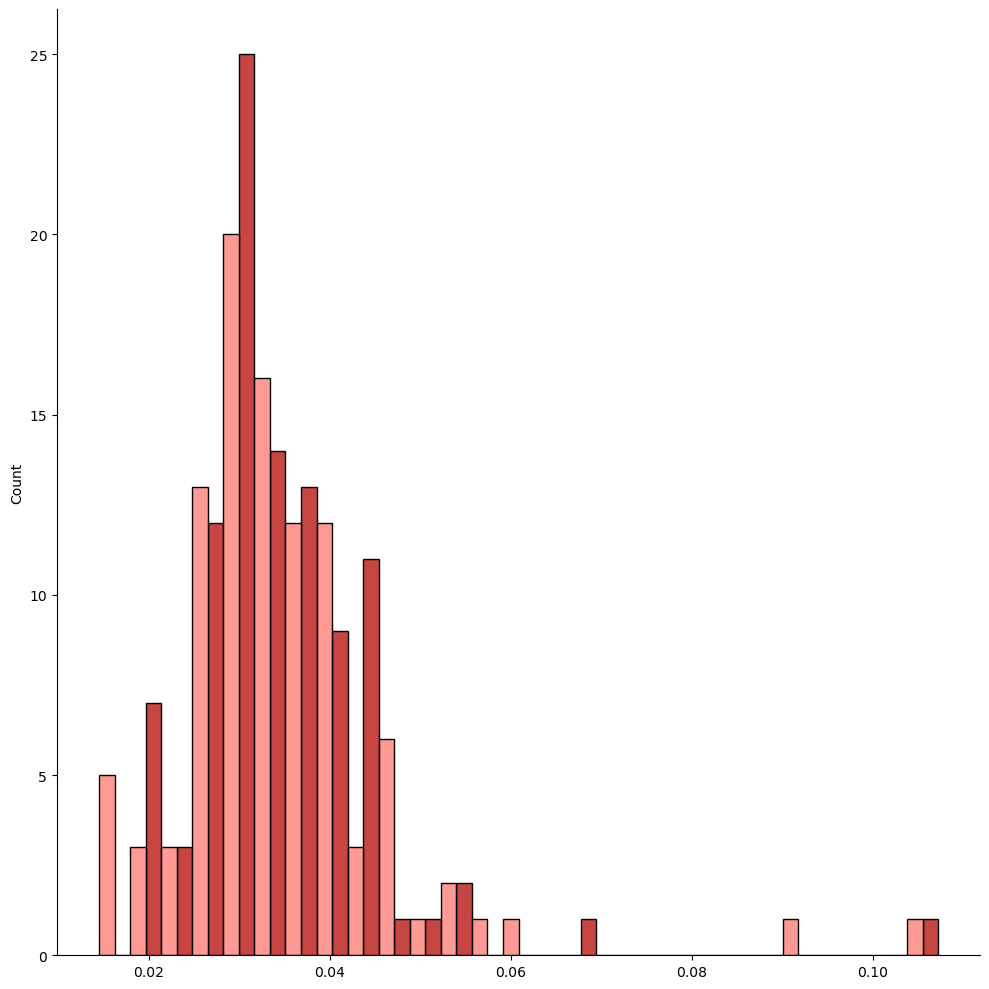

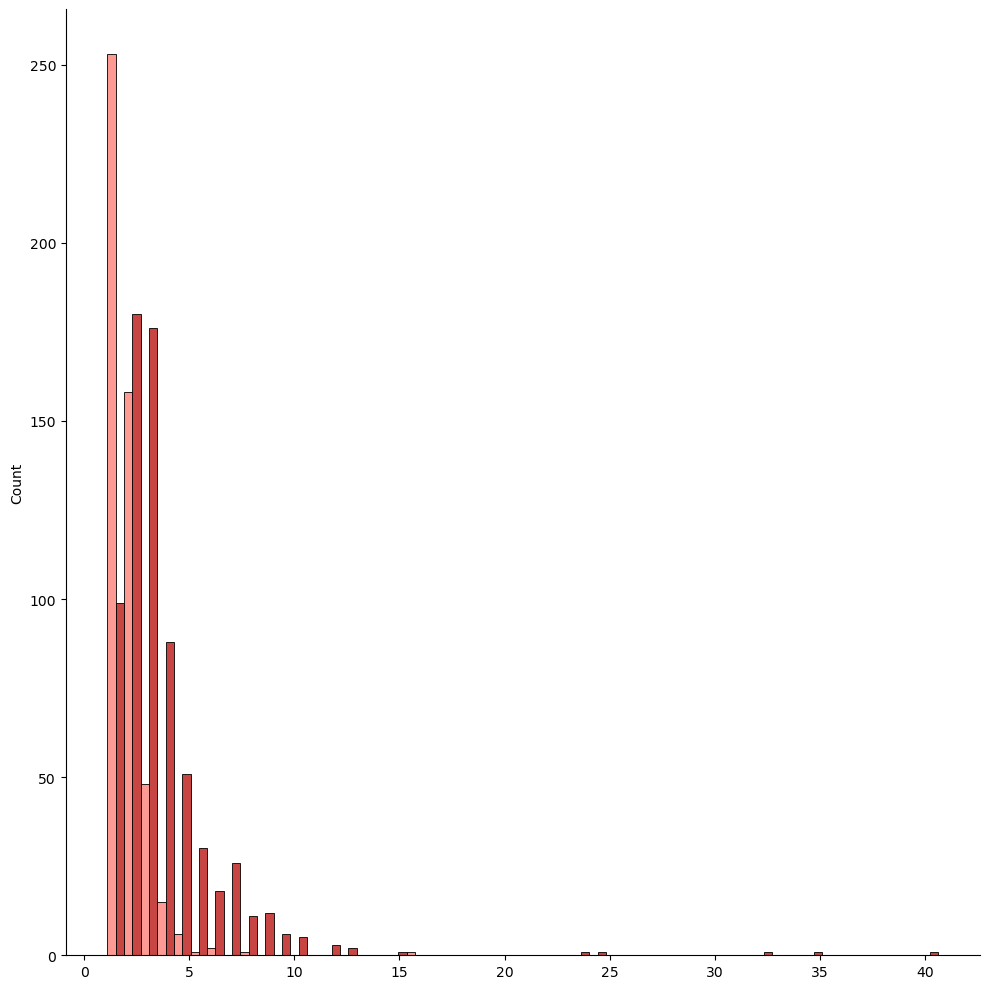

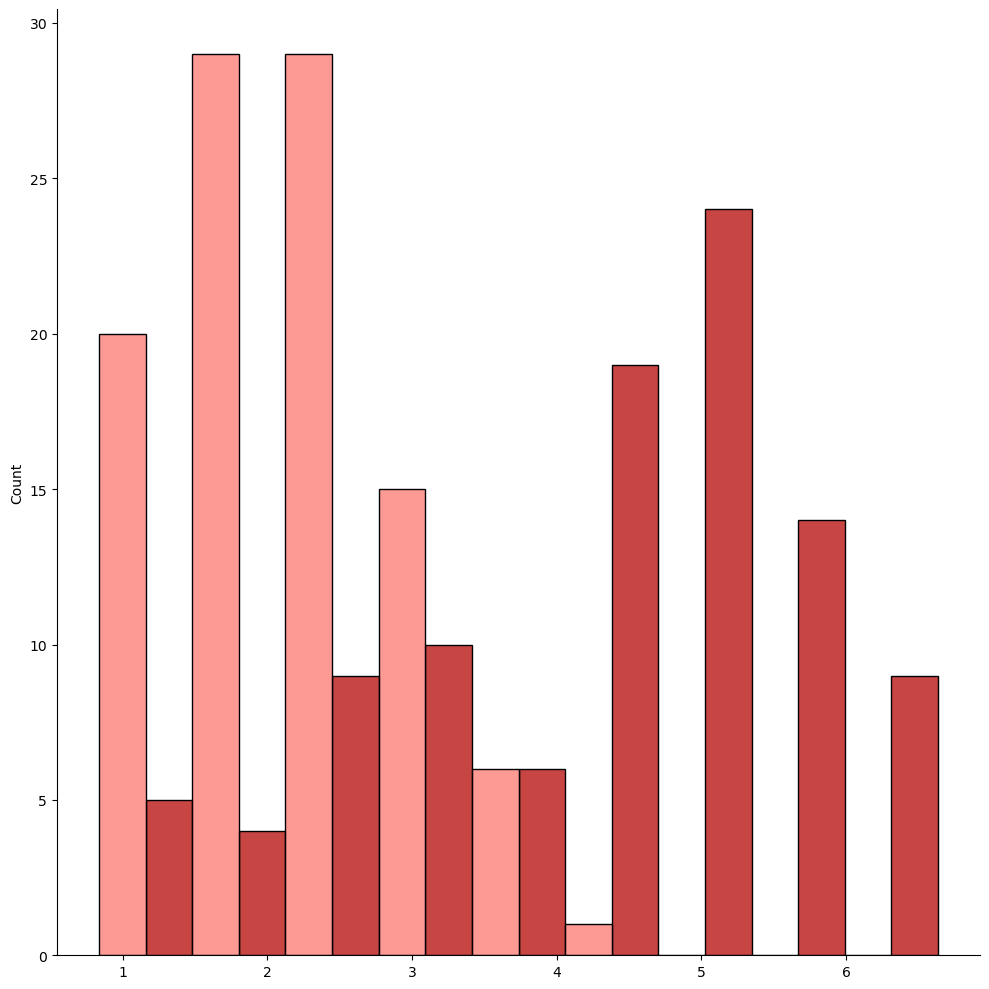

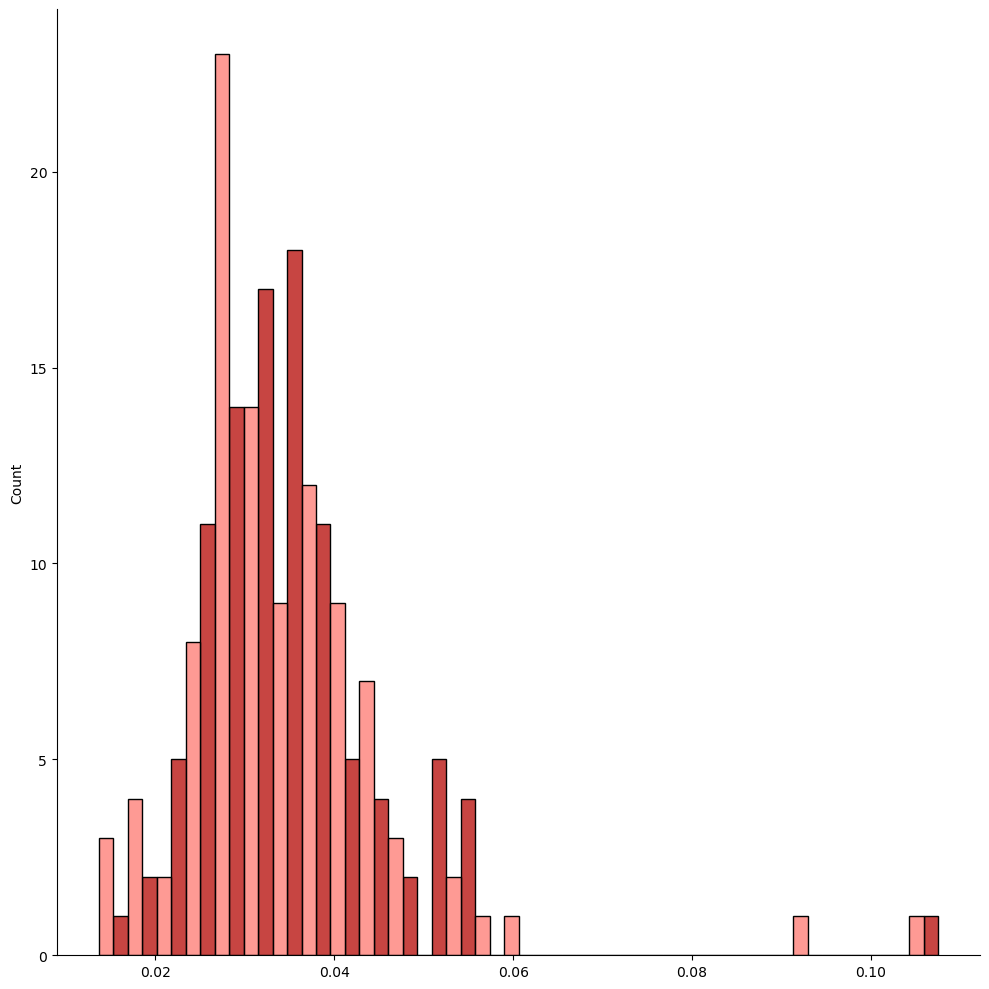

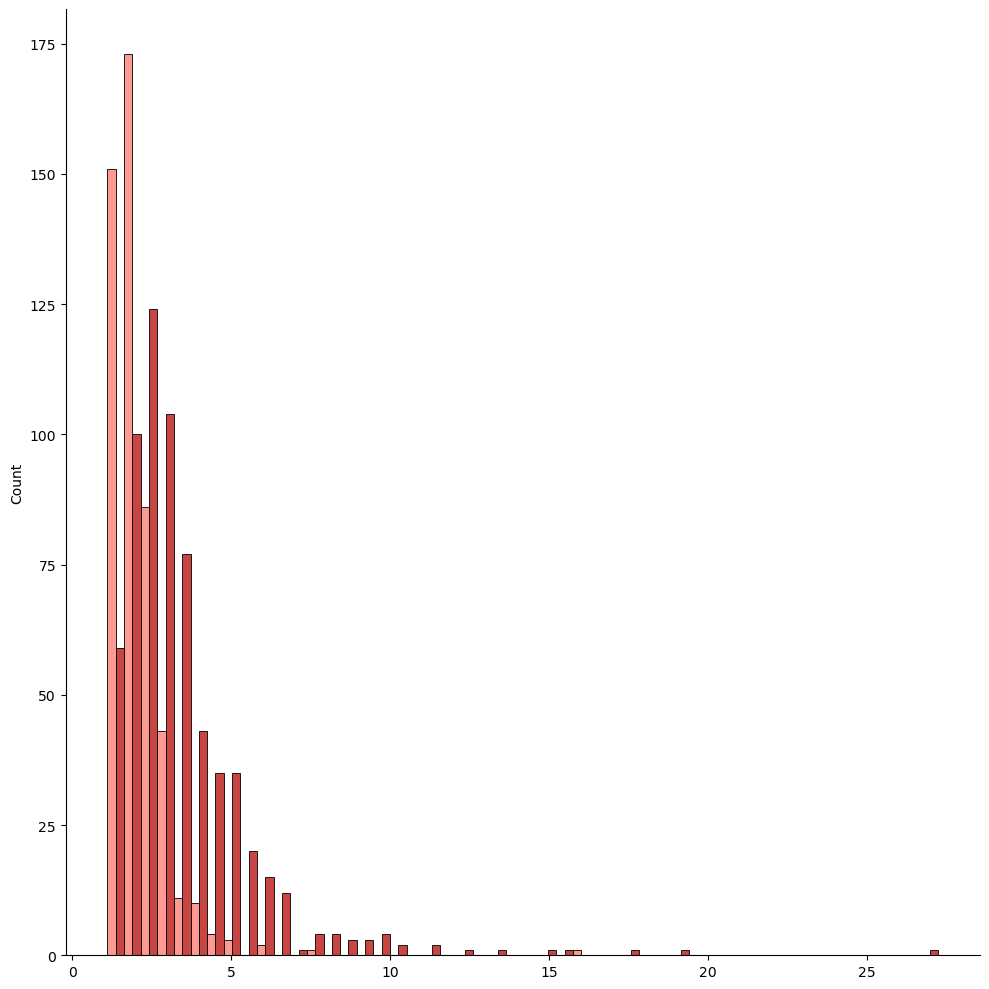

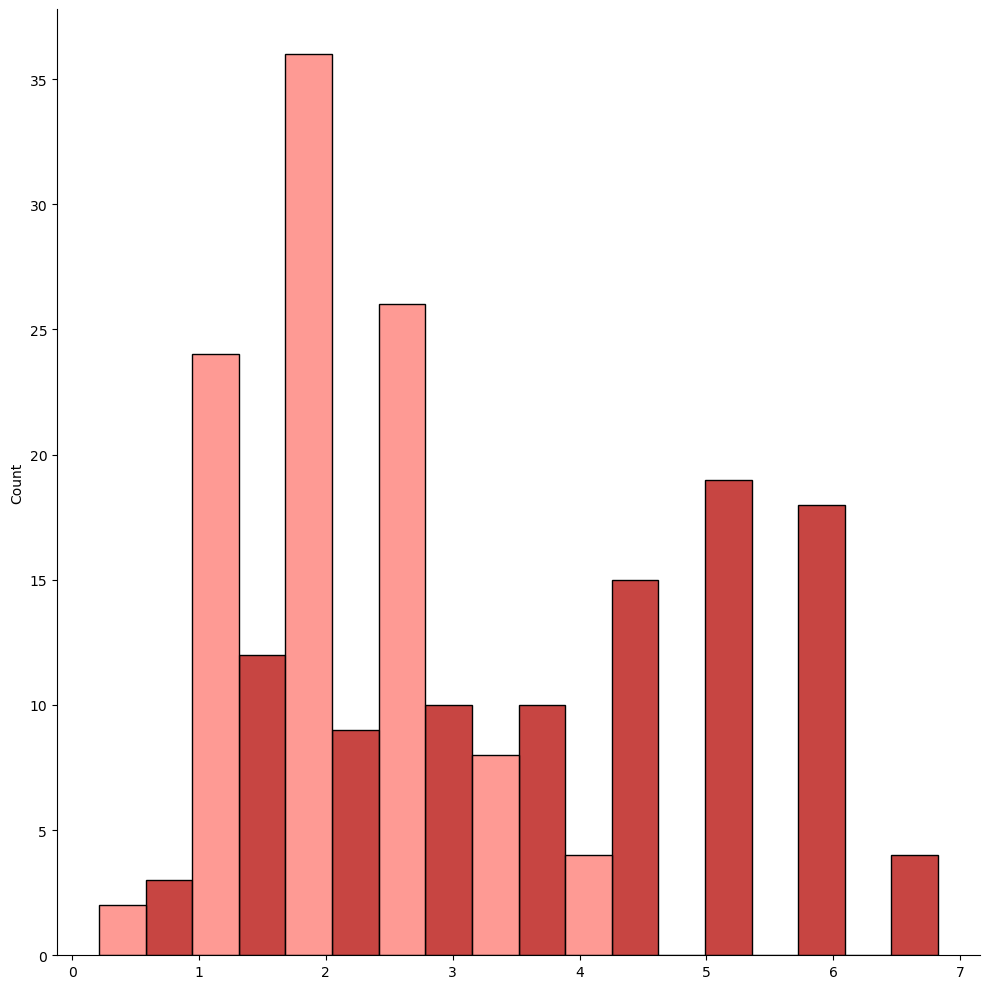

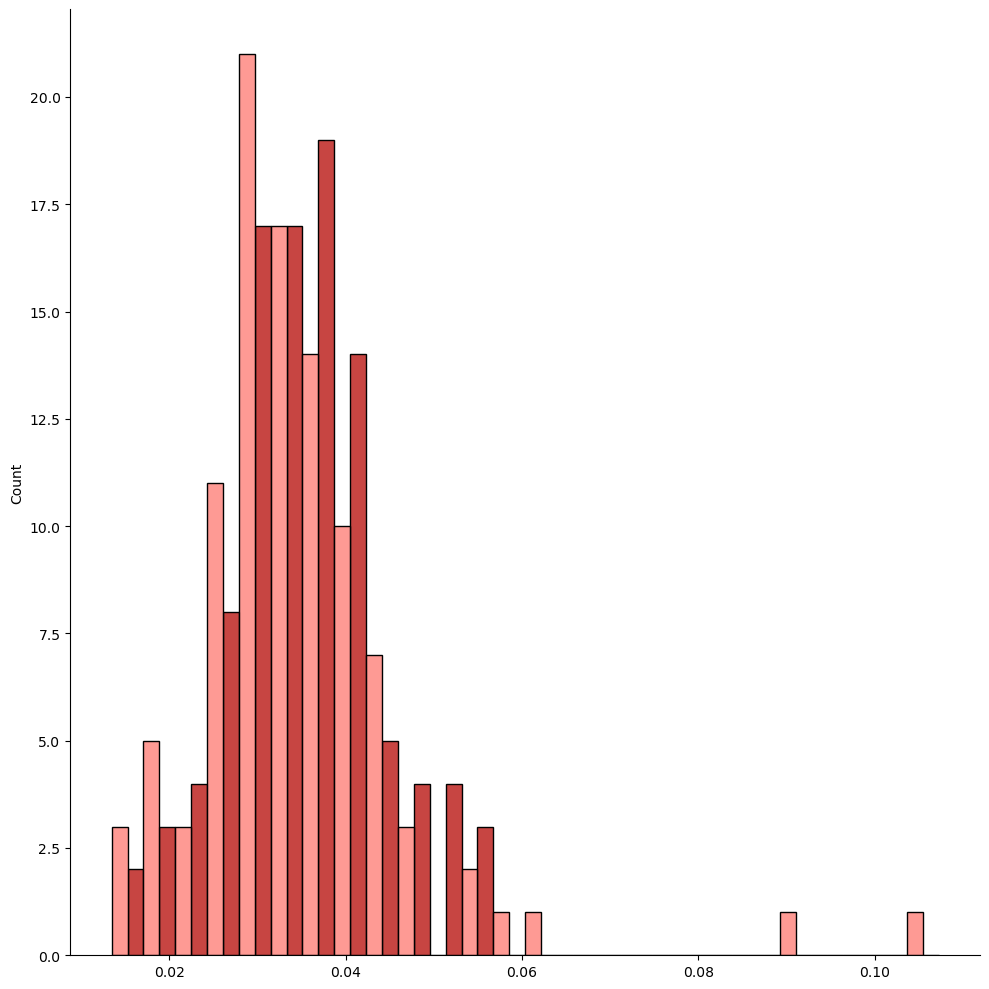

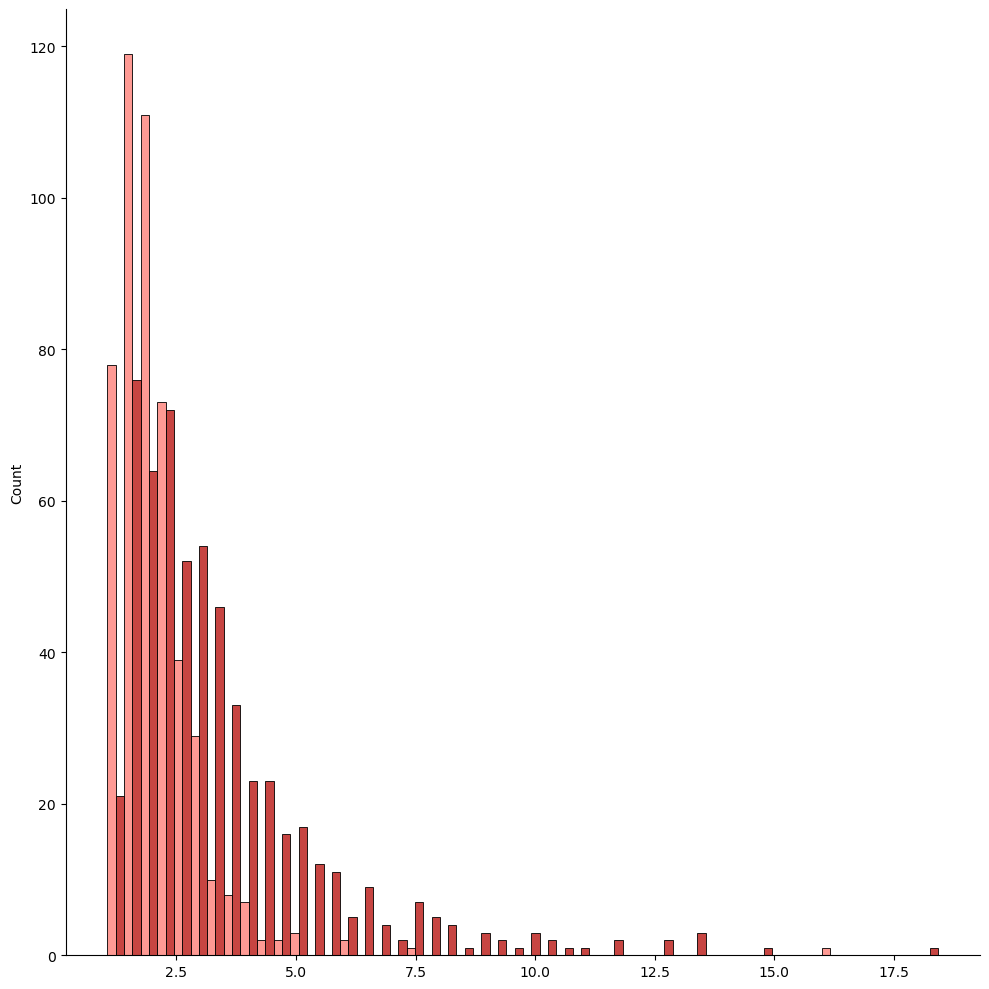

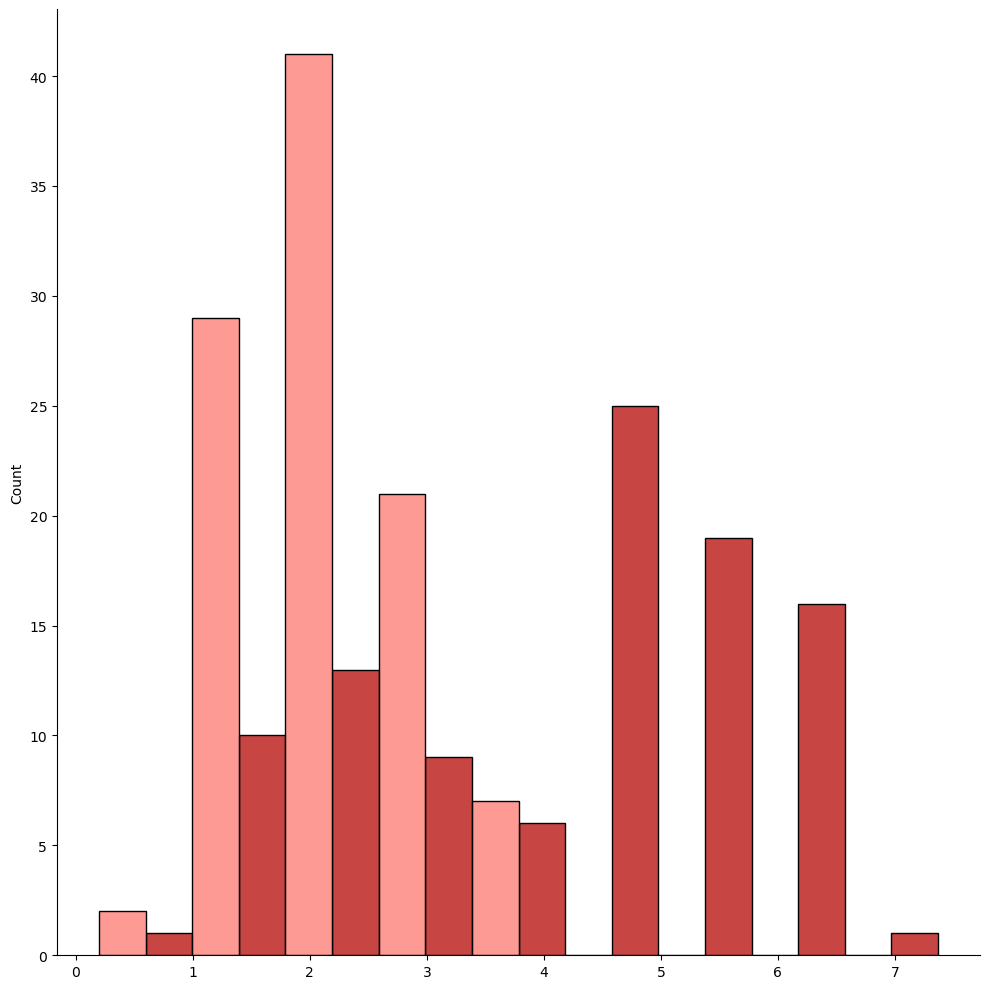

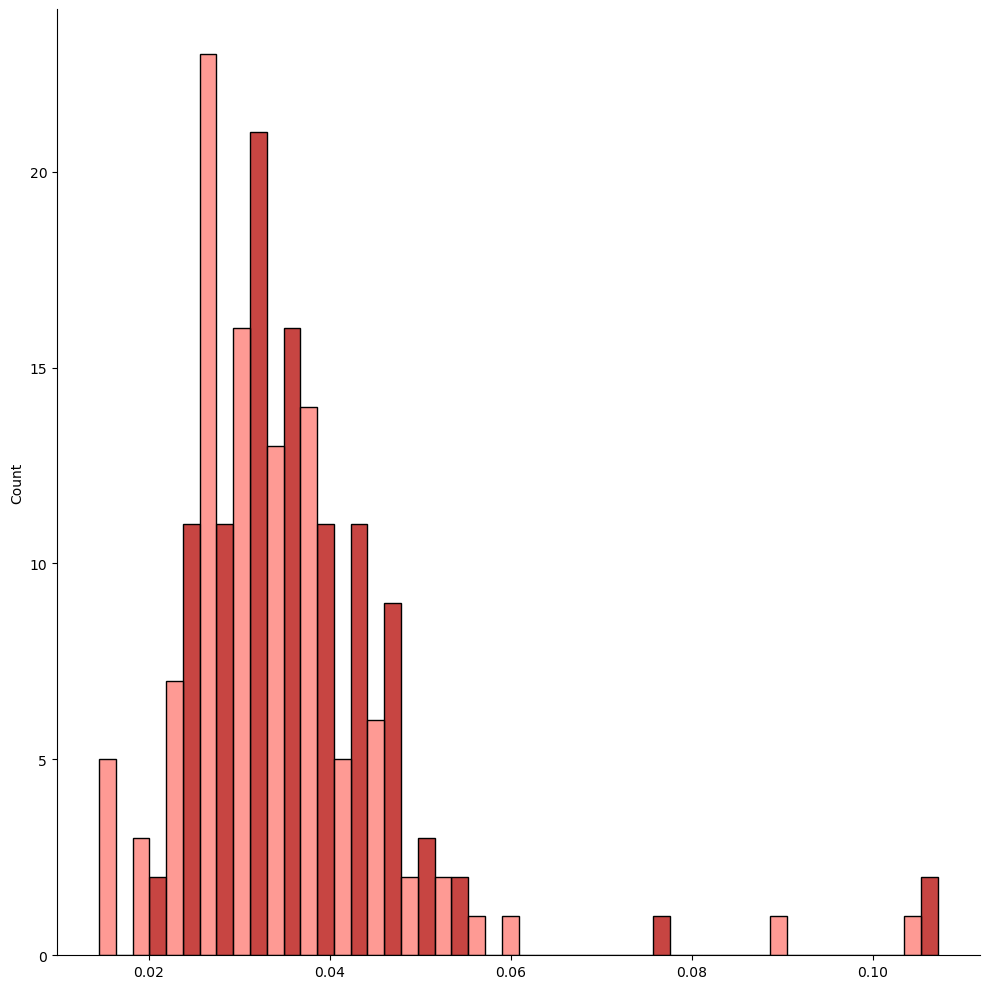

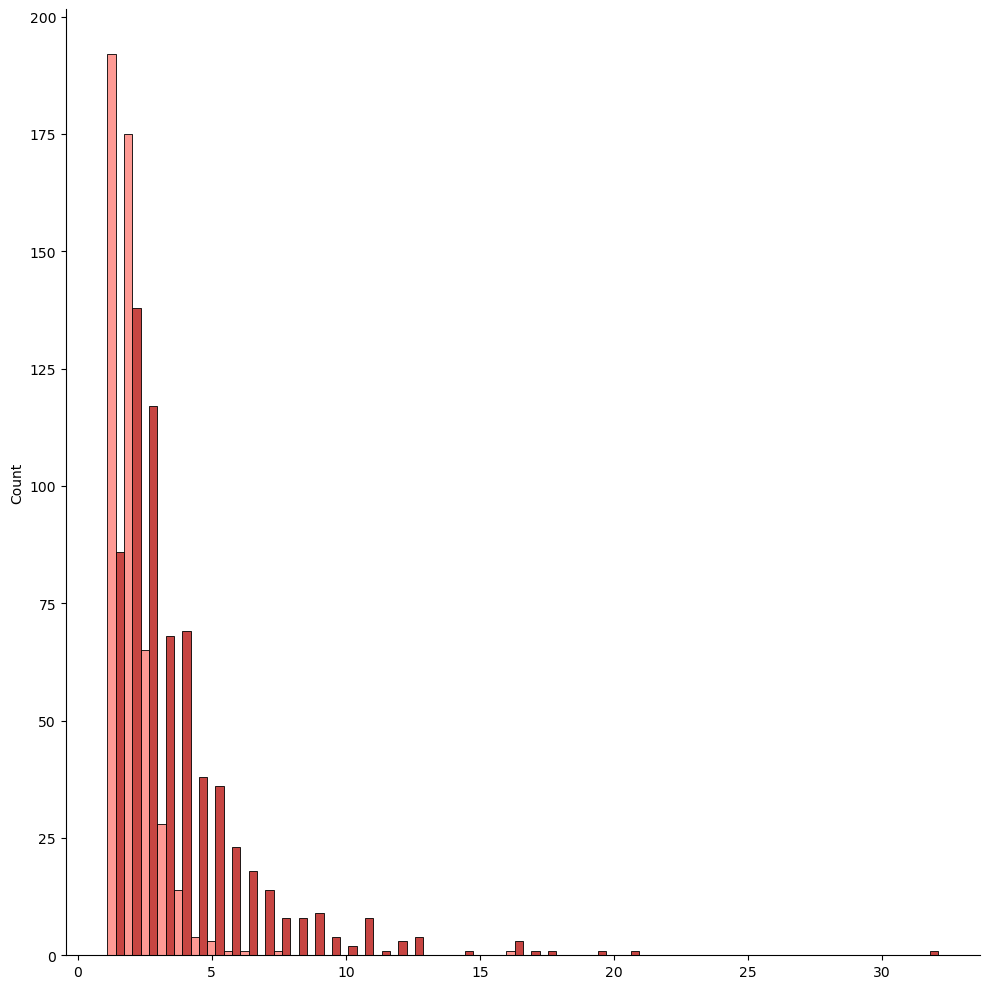

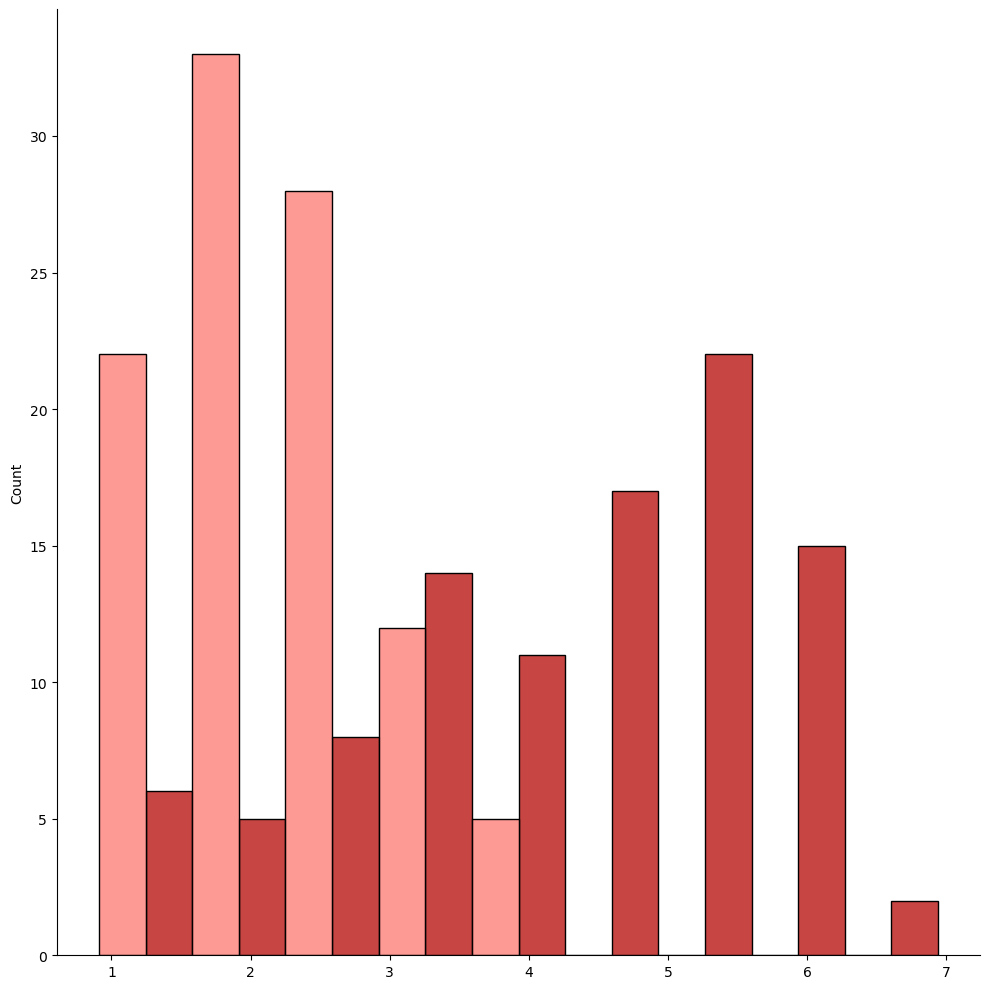

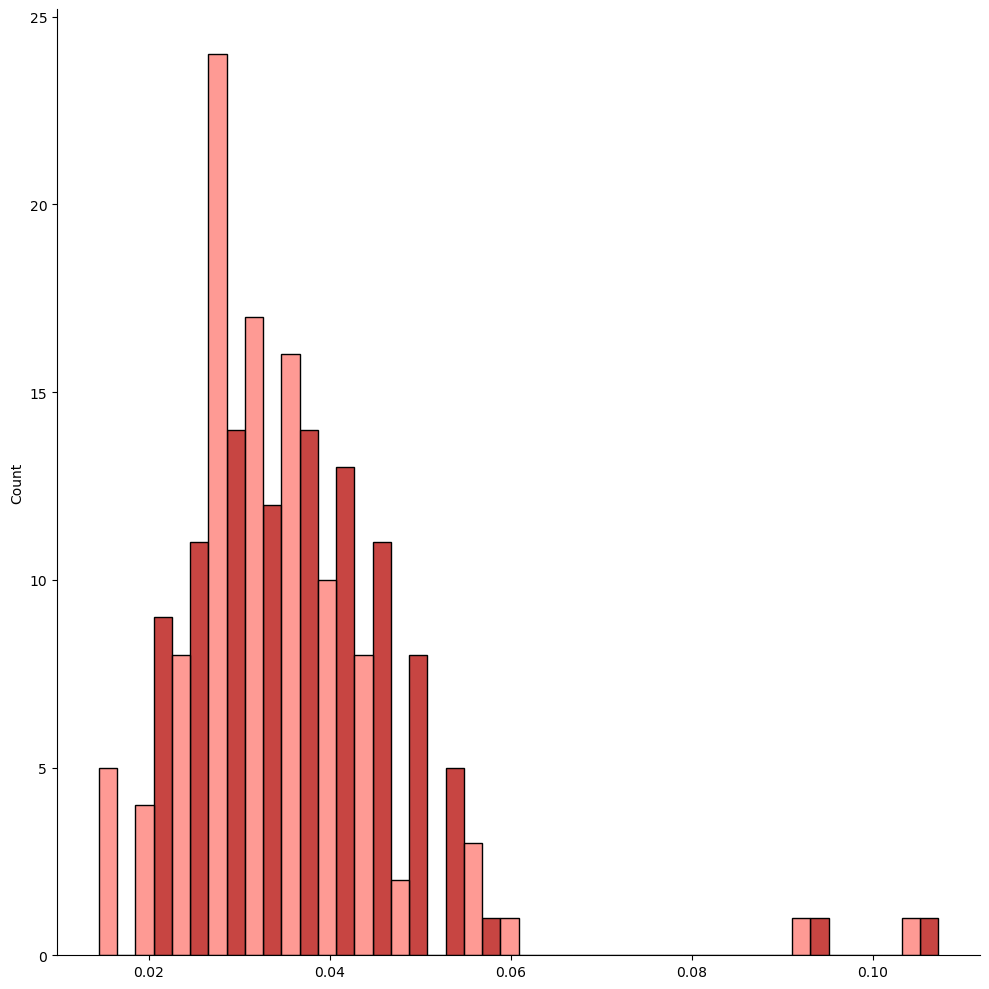

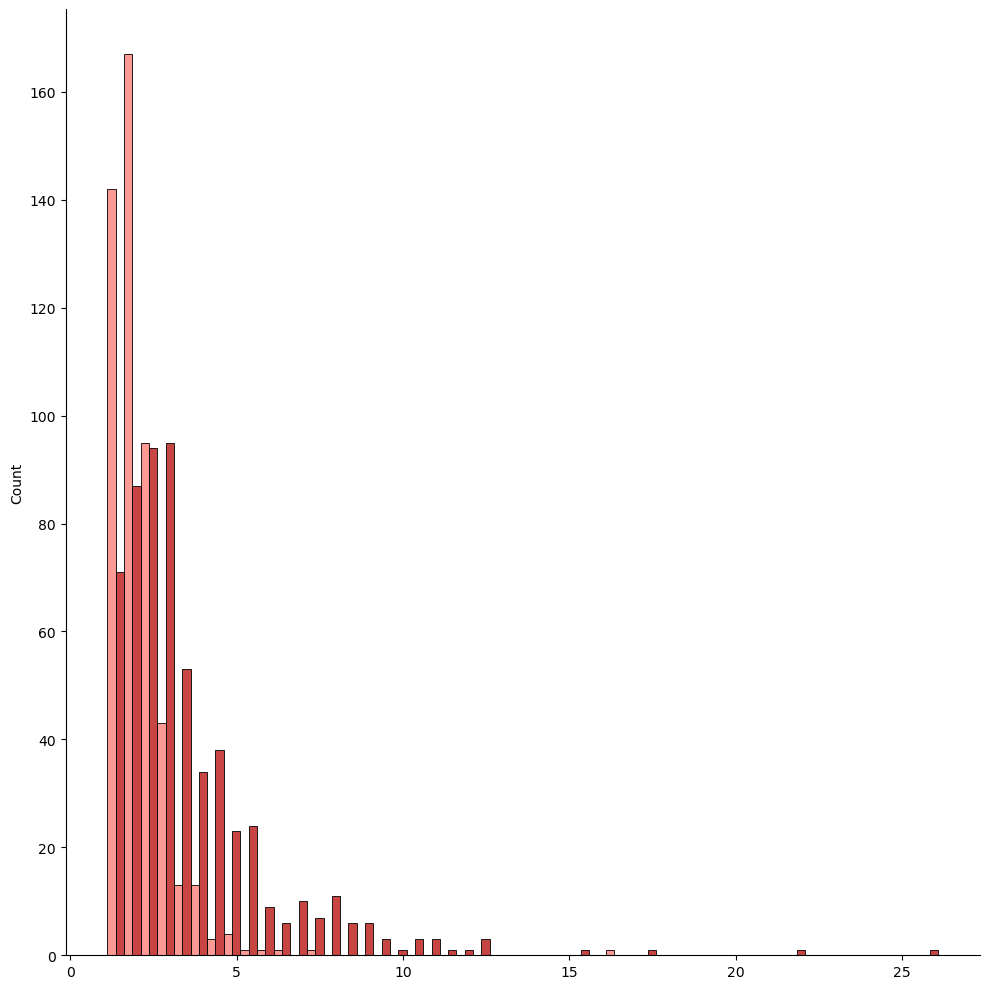

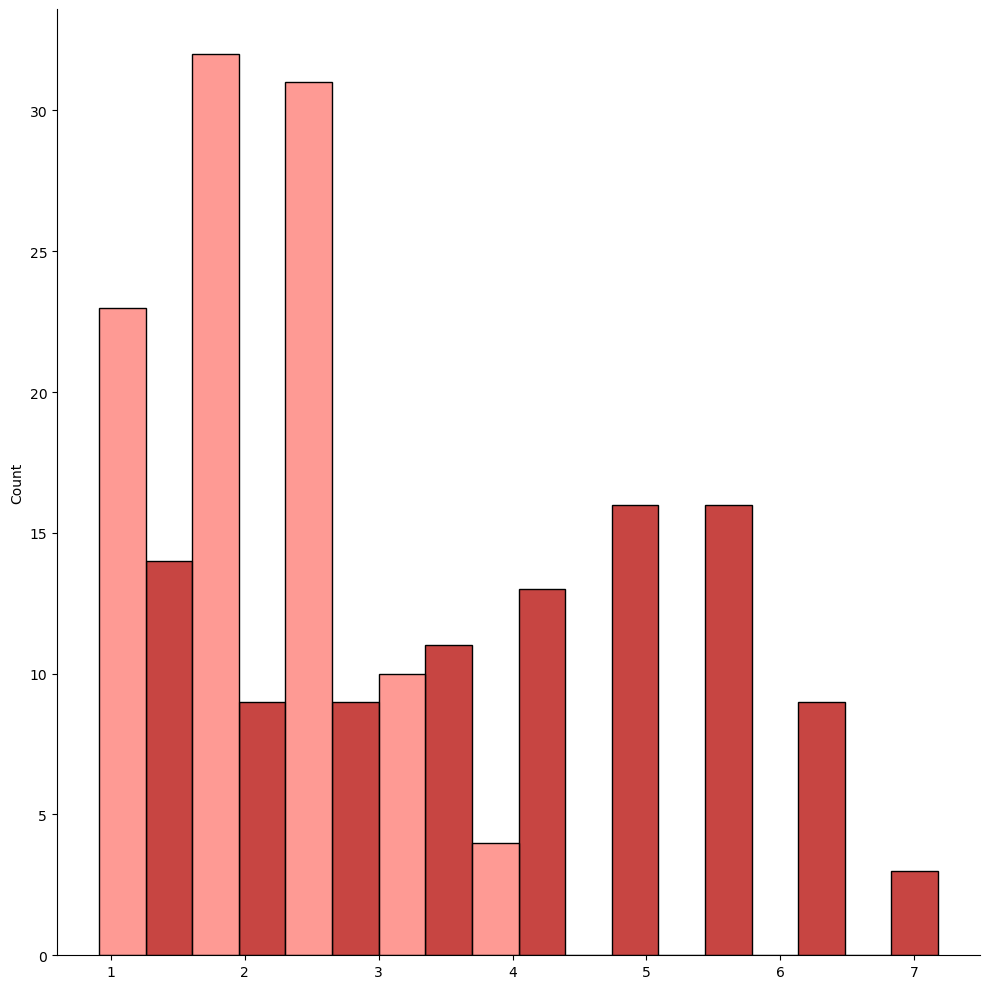

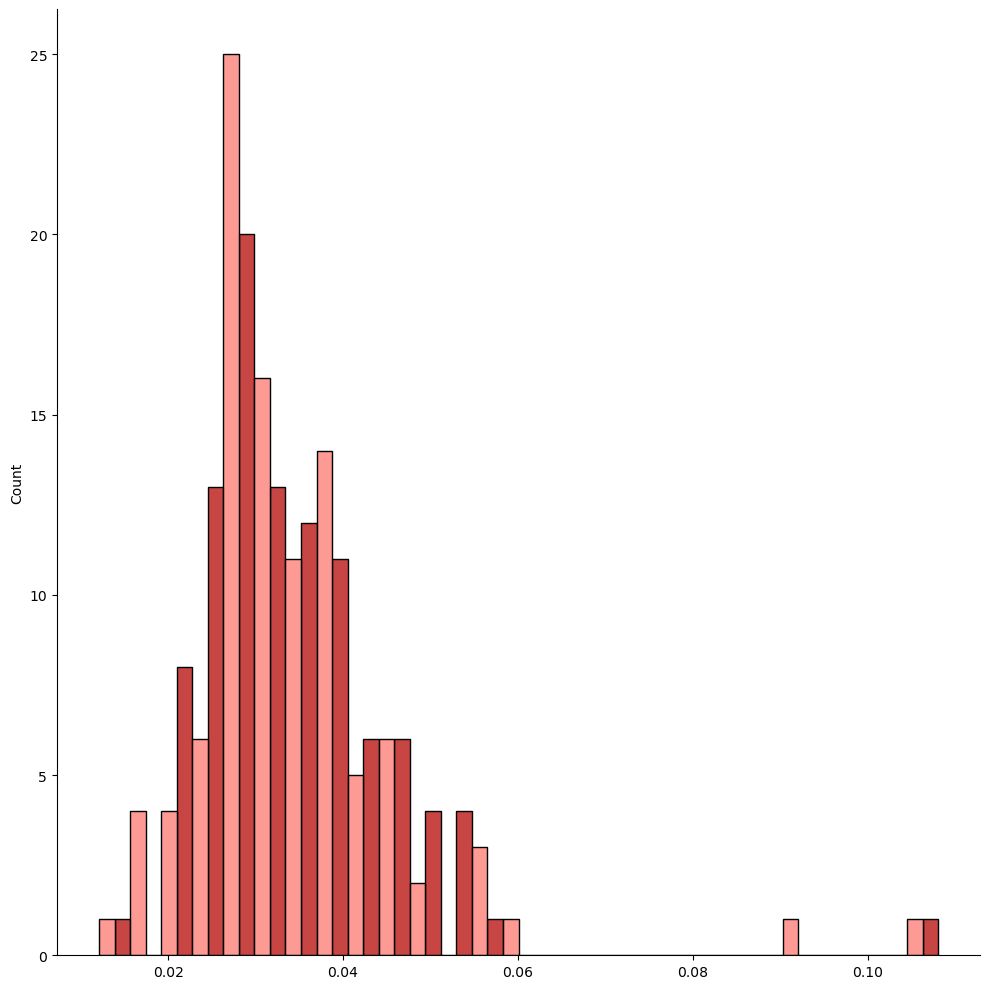

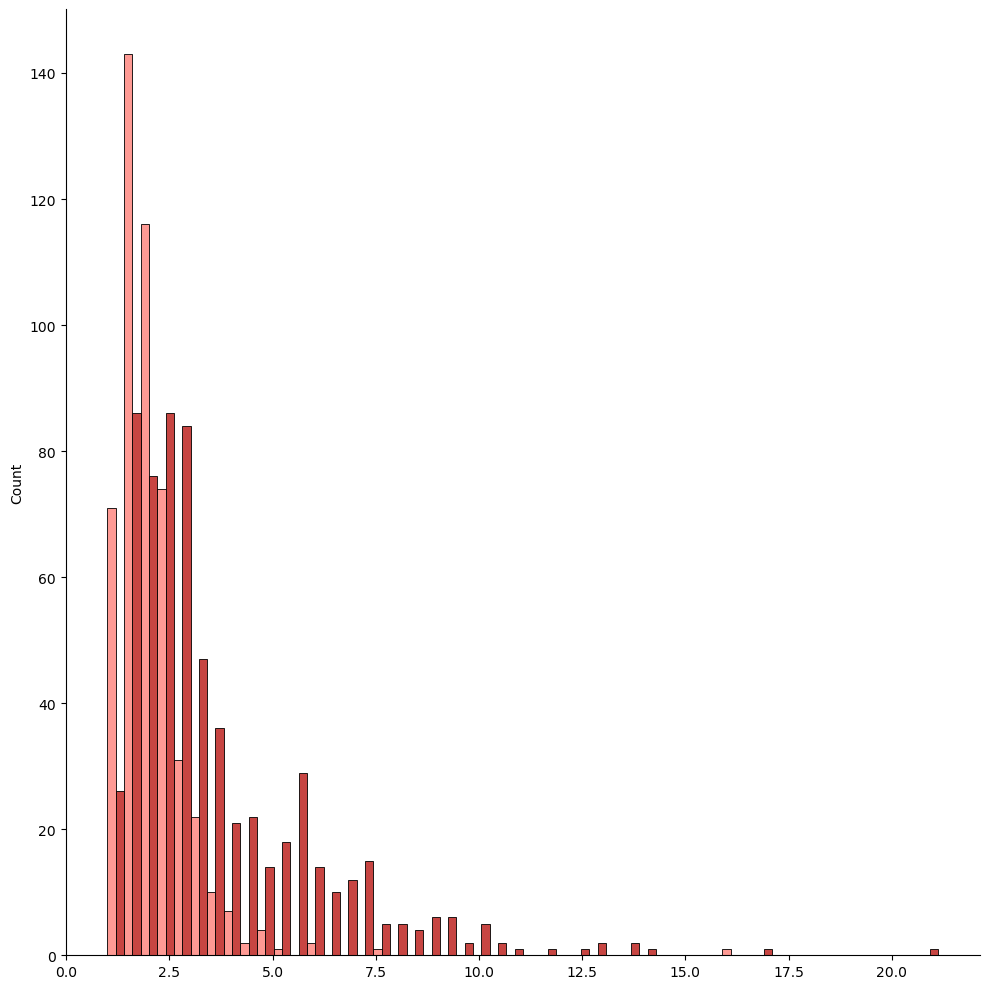

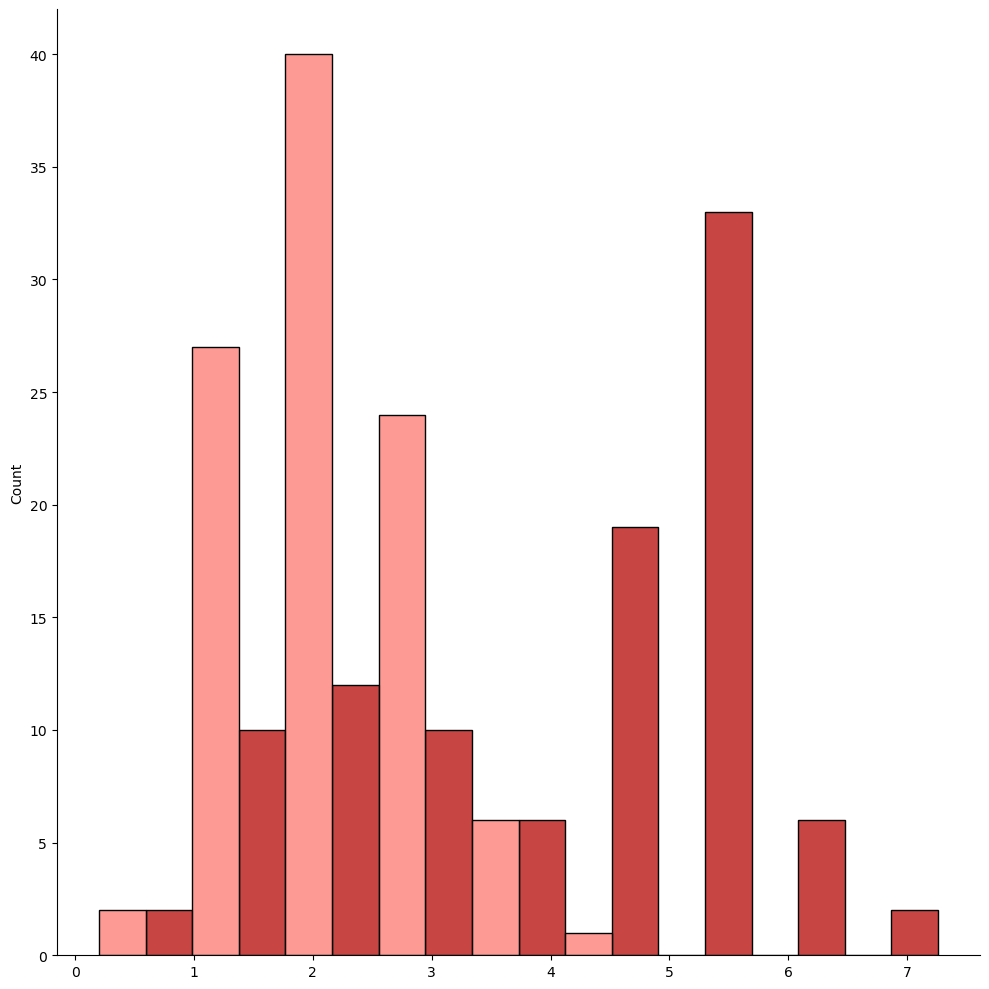

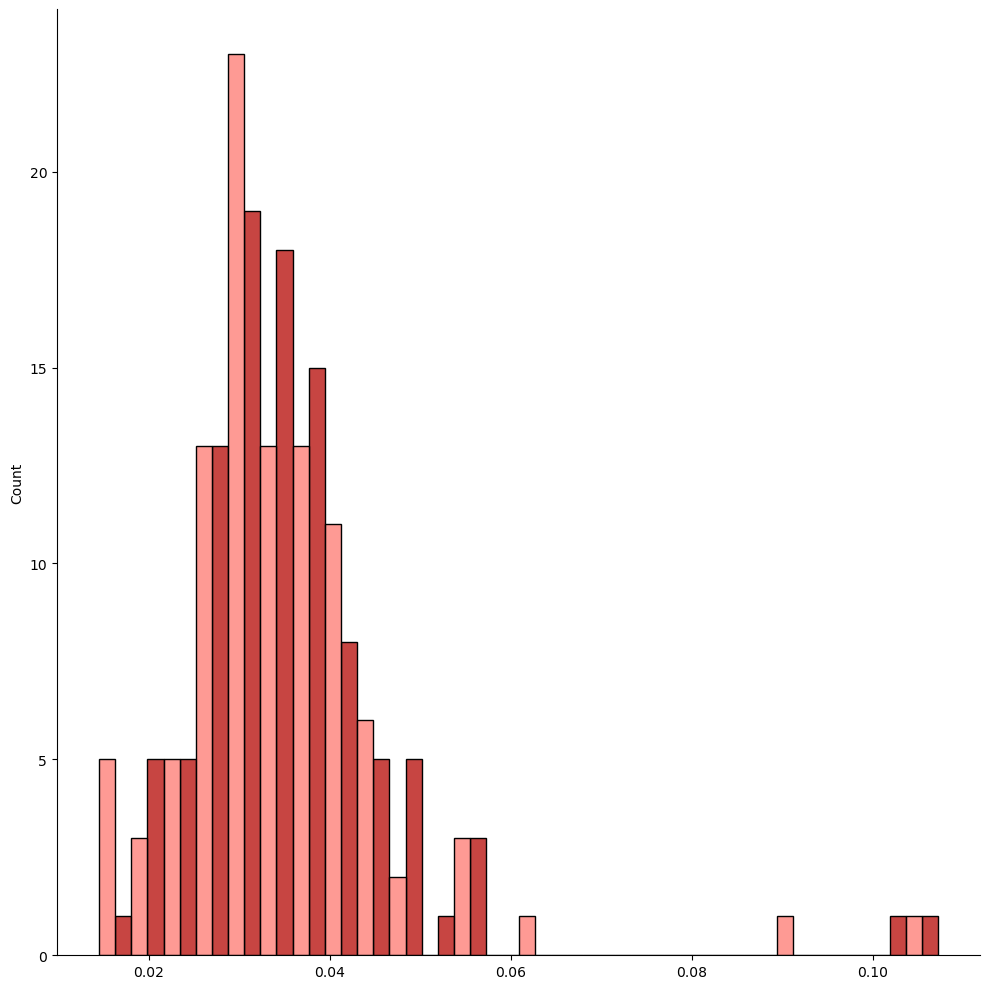

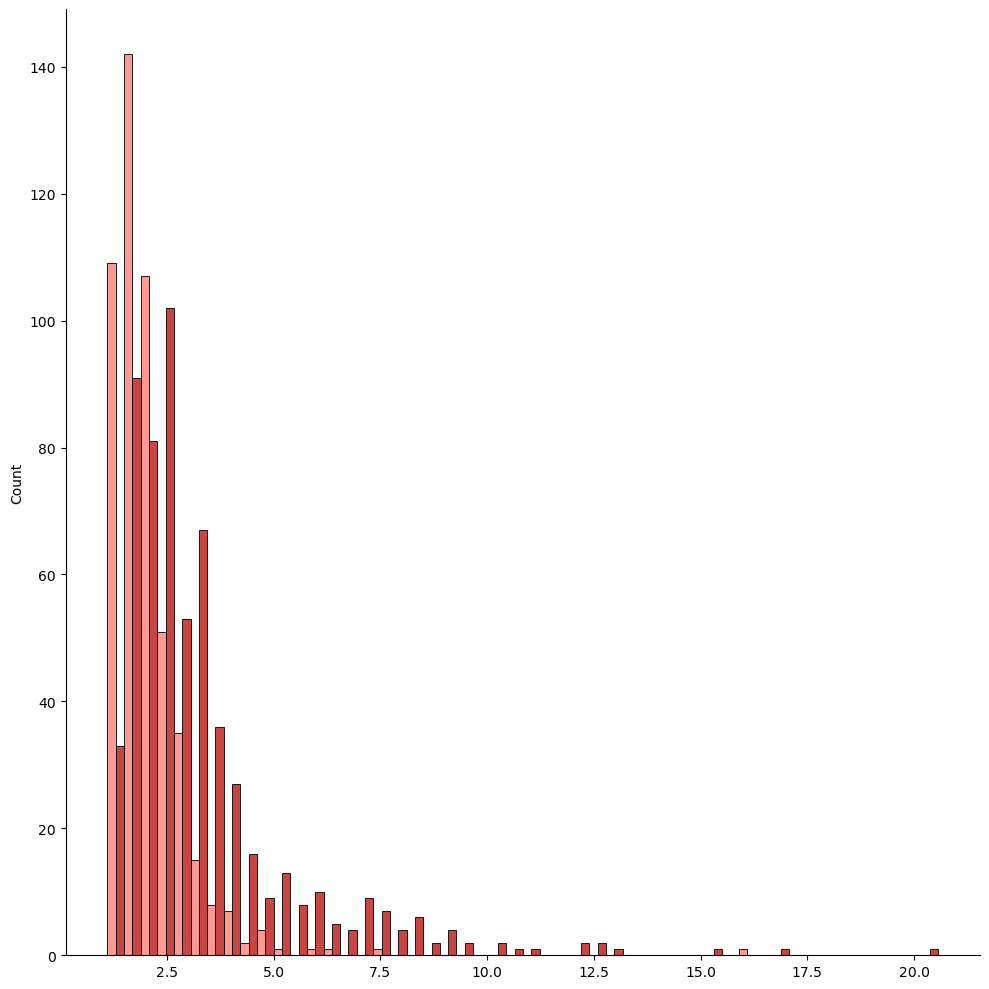

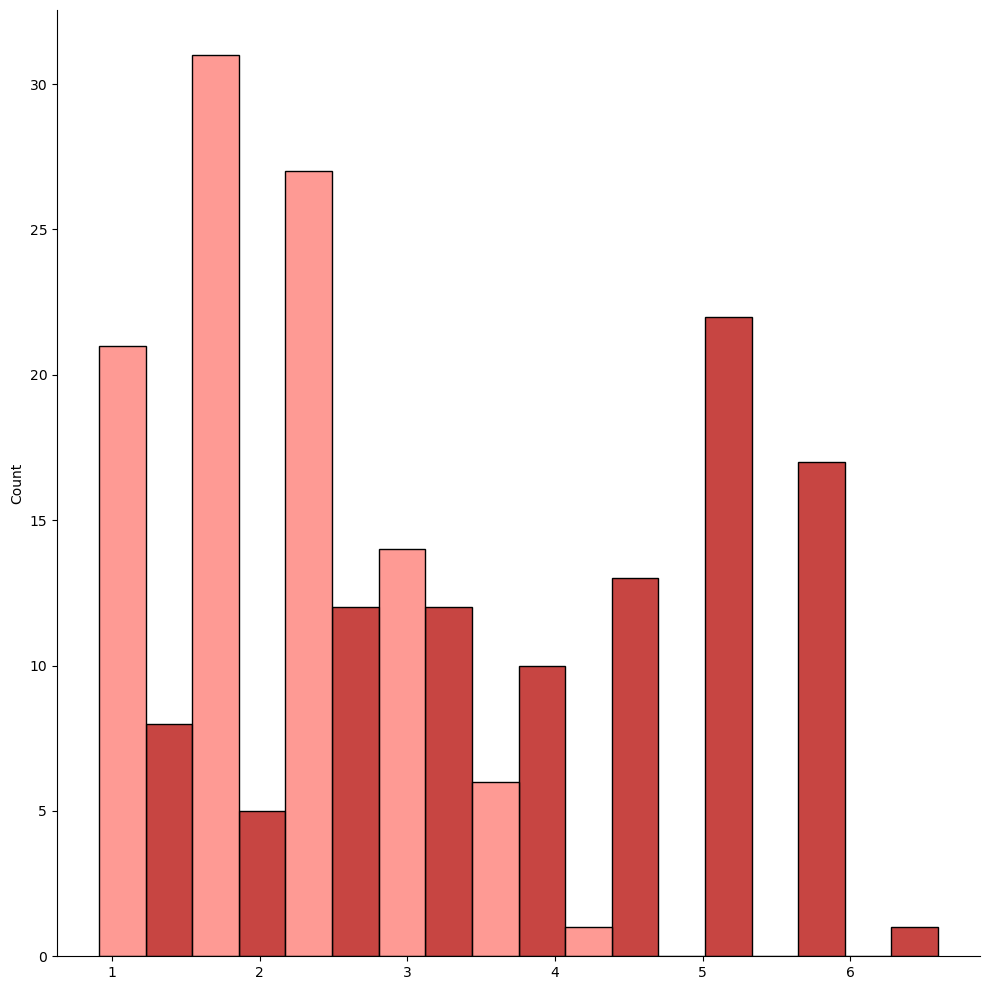

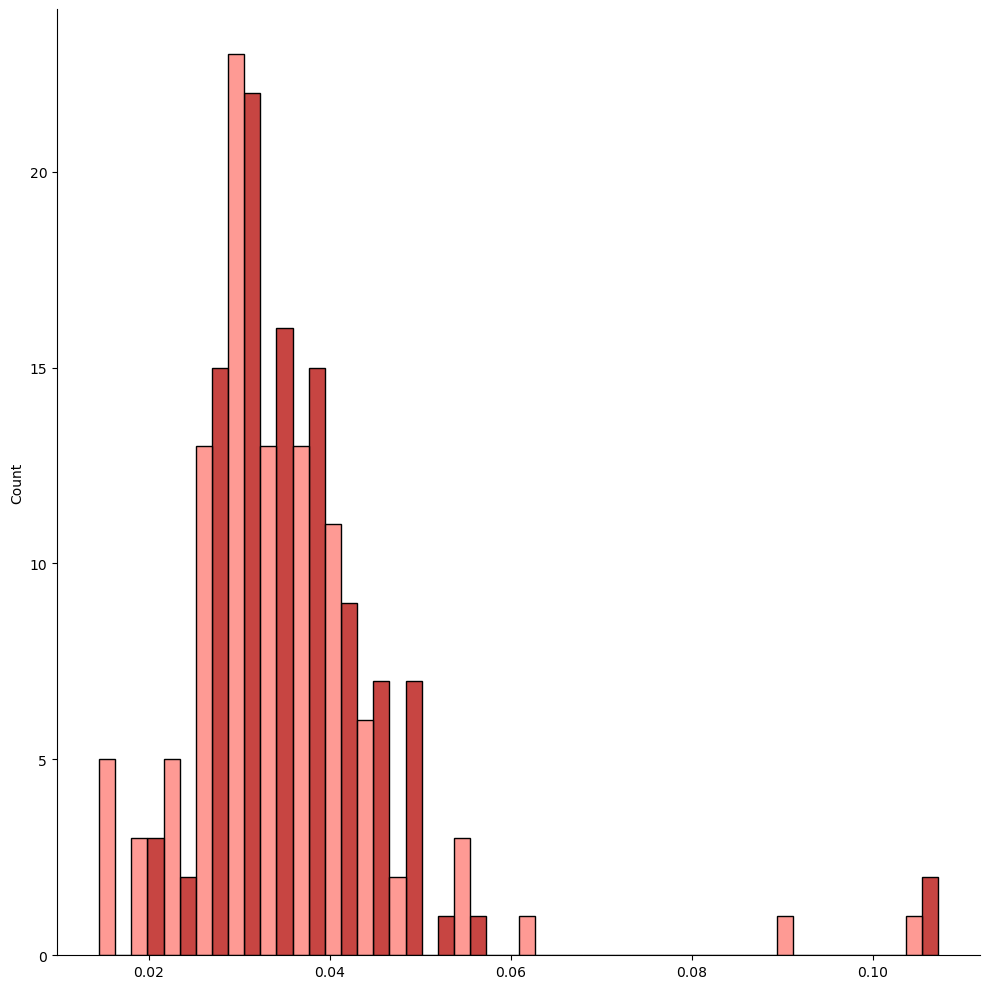

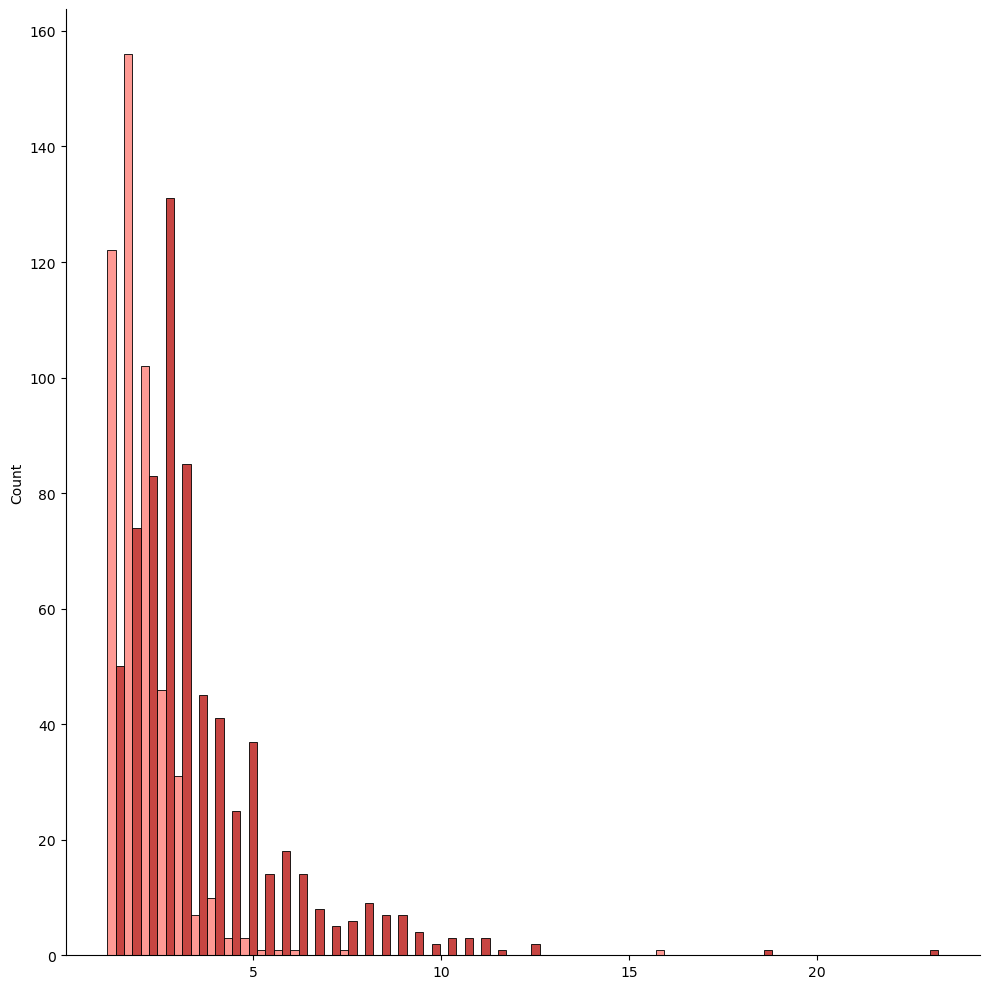

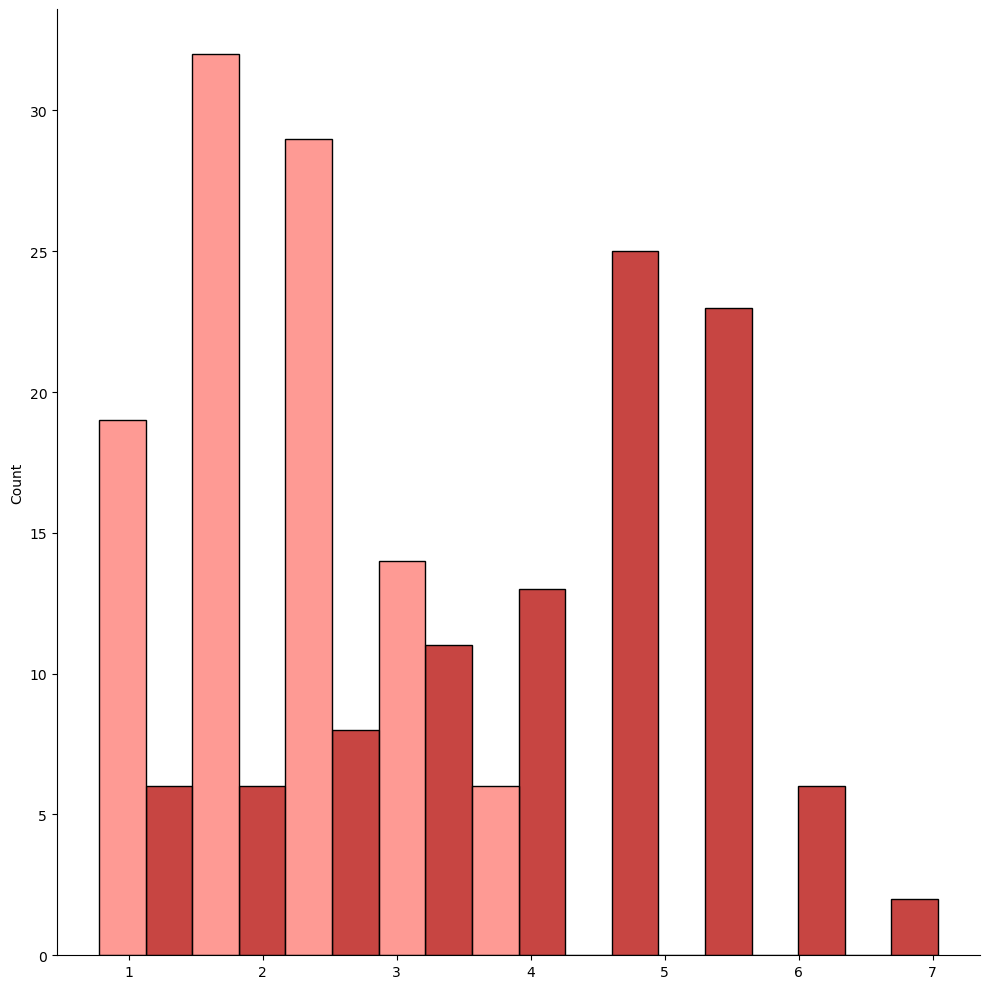

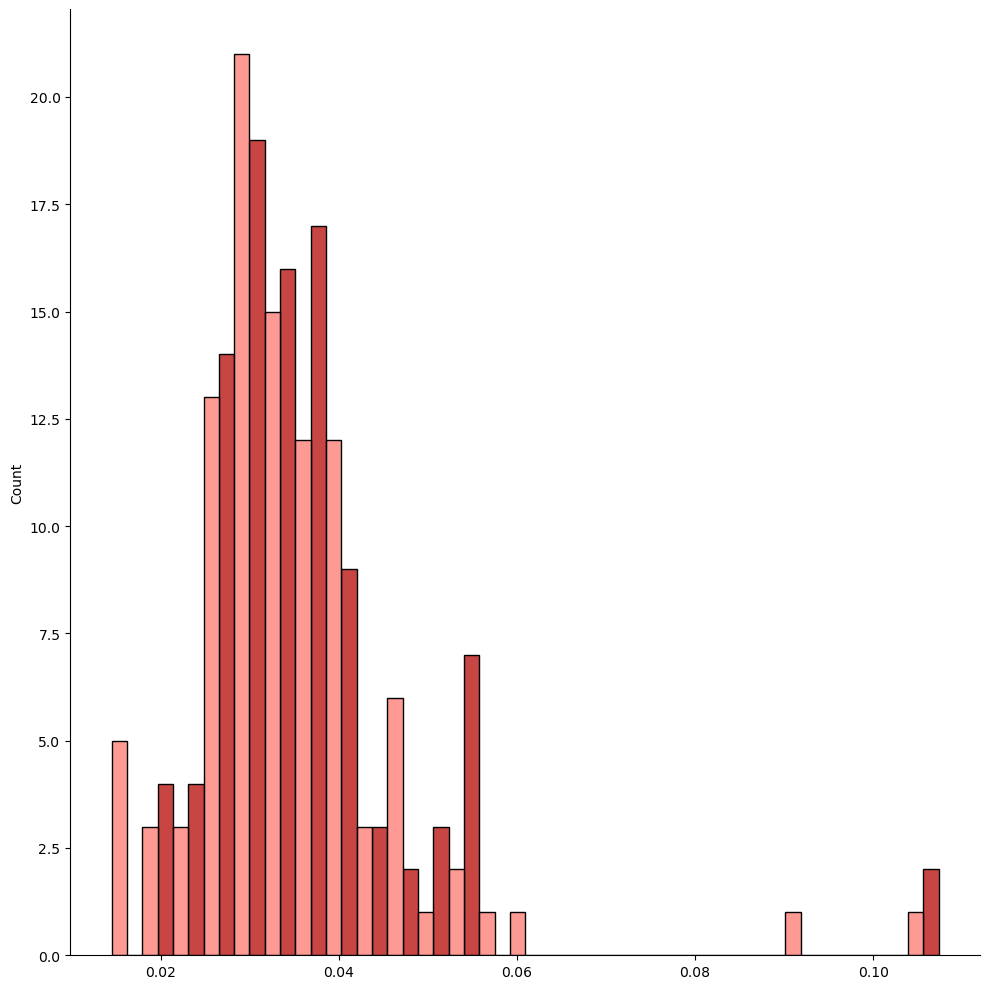

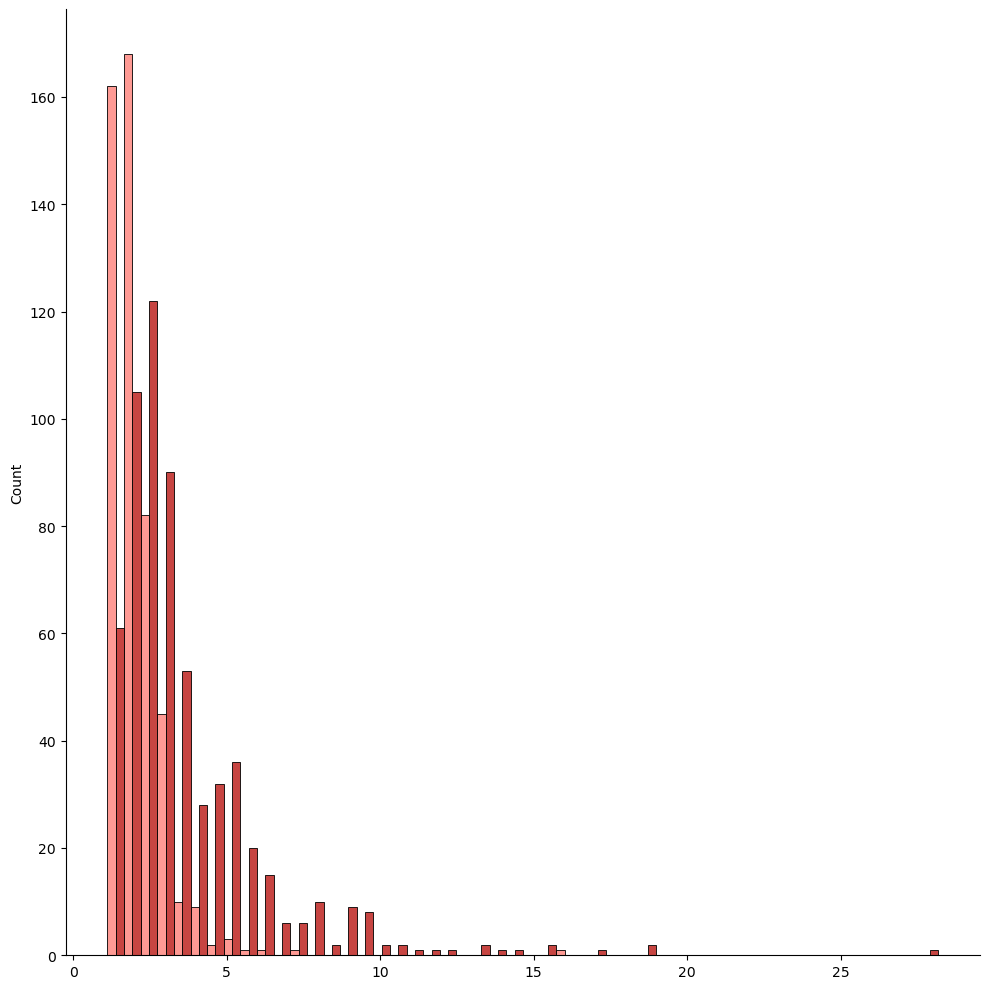

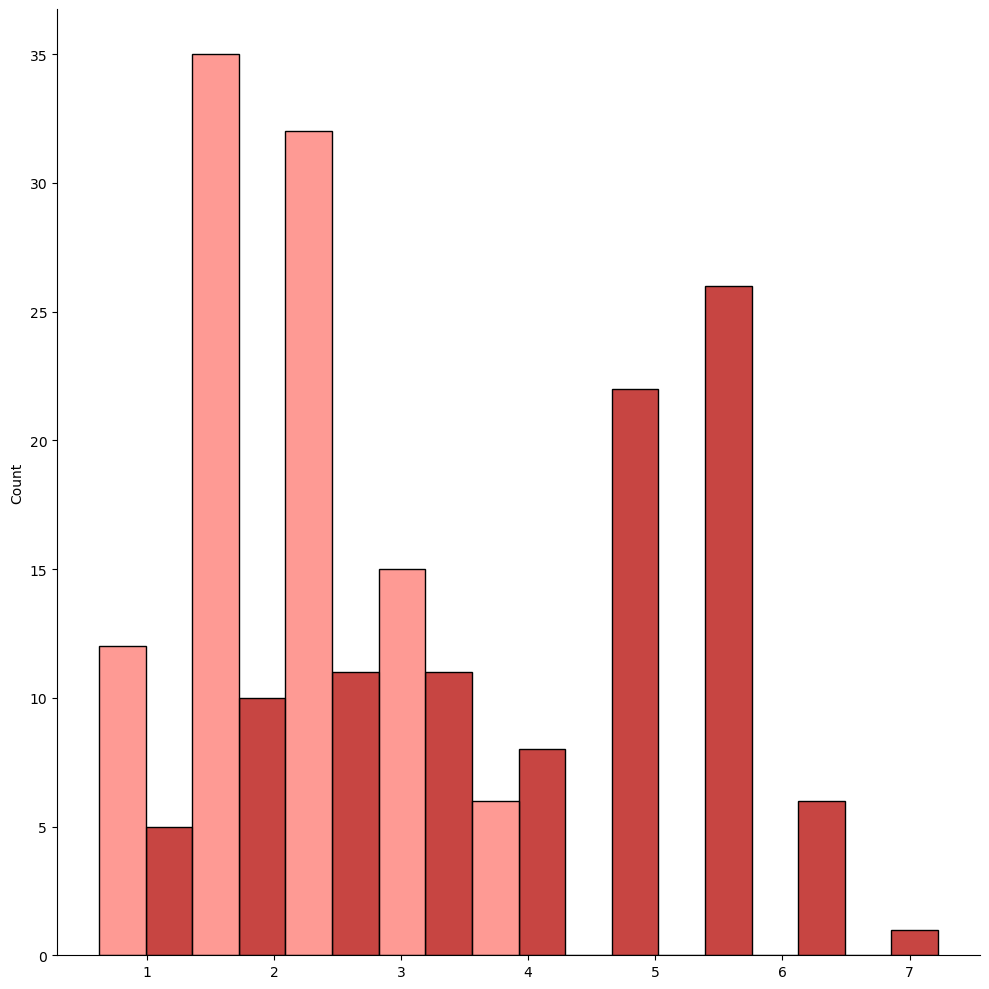

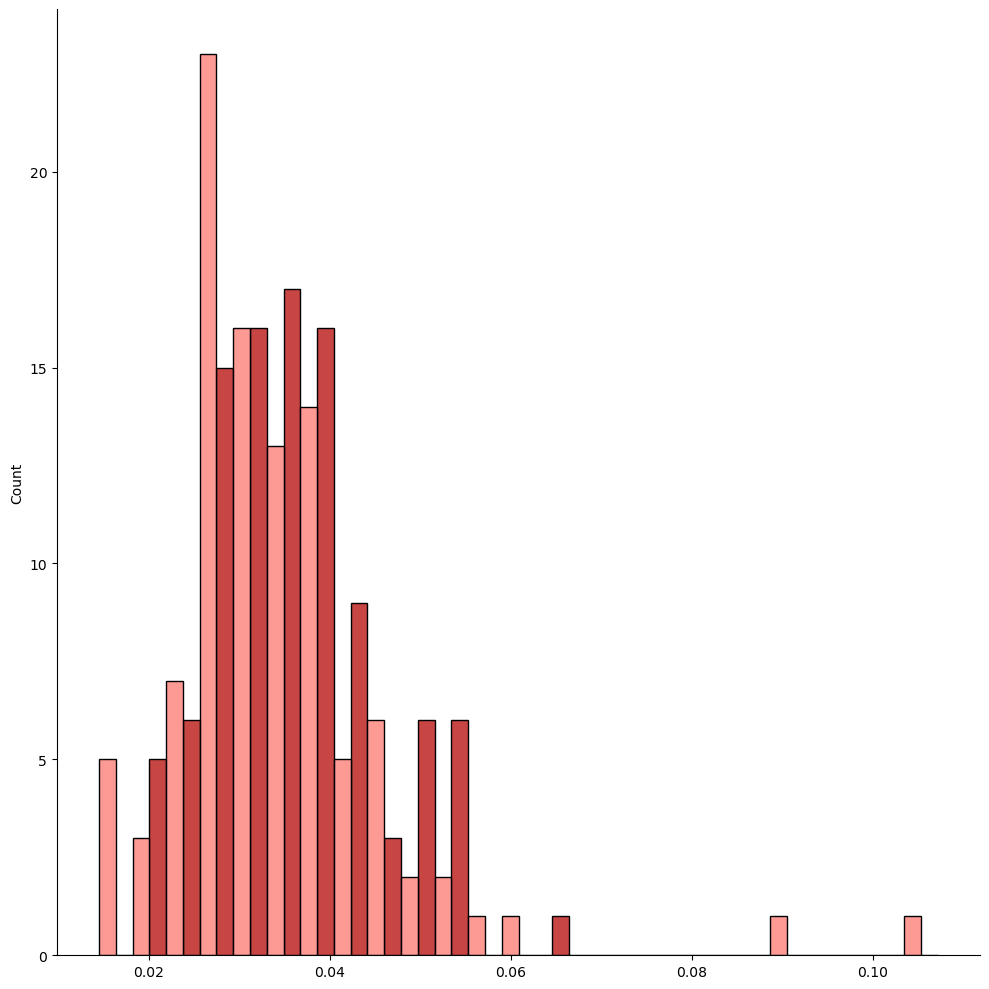

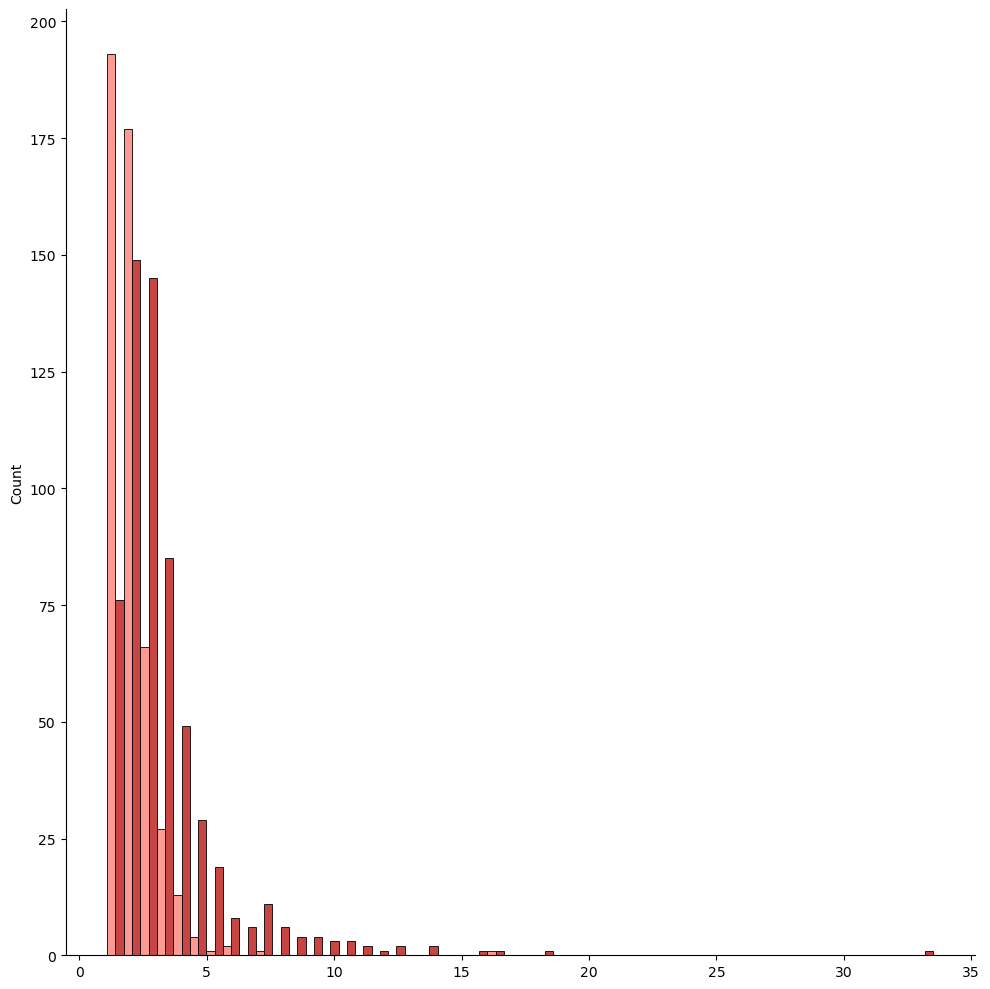

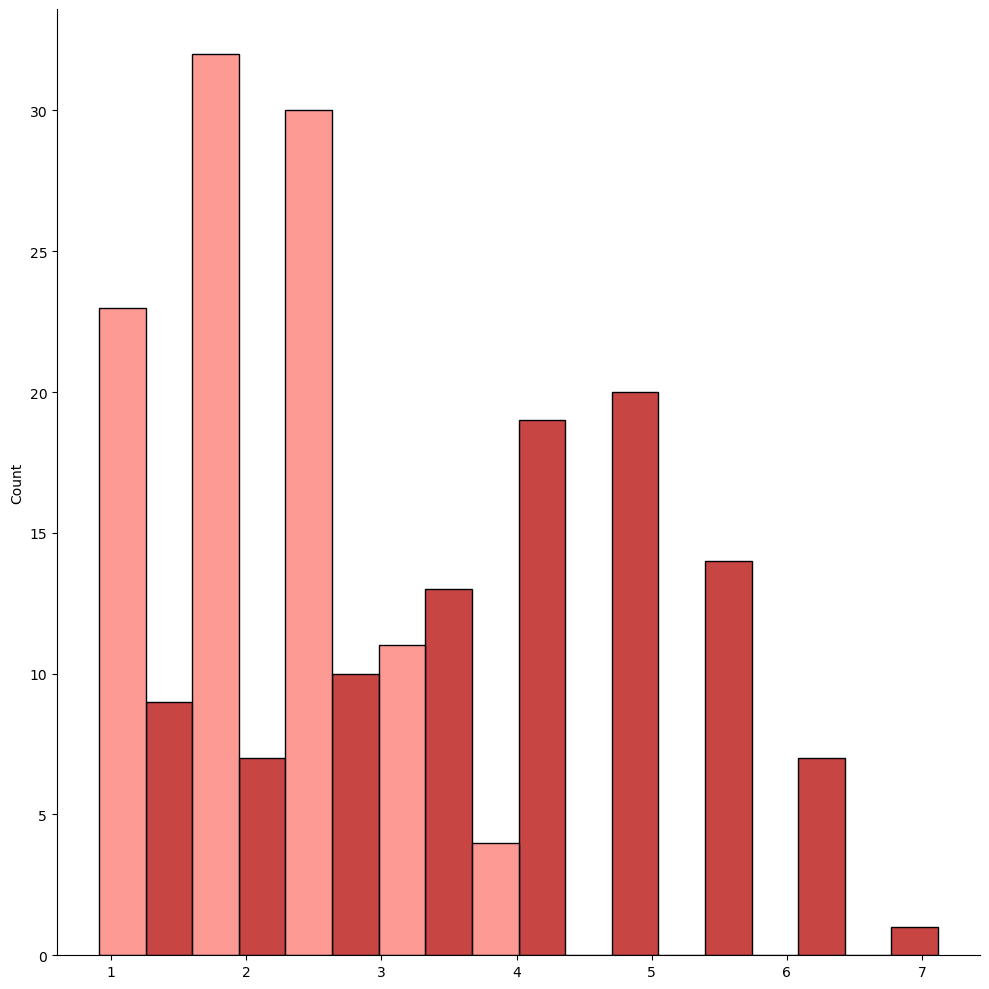

In [96]:
a = [1.,1.,1.]
mult = torch.Tensor(a)
latent_size = 64
Grassdecoder = GRASSDecoder(latent_size=latent_size, hidden_size=256, mult = mult.to(device))
Grassdecoder = Grassdecoder.to(device)
Grassdecoder.eval()
checkpoint = torch.load("output/" + dataset_name + "P" +p + "eps" + eps+ "-best.pth")


Grassdecoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']

#mean_cosine_similarity, lower_bound, upper_bounds, ratio_radios_generados = calculate_cosine_similarity_confidence_interval(10)
resultR, resultL, resultT = calculate_cosine_similarity_confidence_interval(10, latent_size, Grassdecoder, mult)

In [97]:
mean, lower, upper = resultR
print("Radius")
print("mean", np.round(mean,2))
print("bounds", np.round(lower,2), np.round(upper,2))
mean, lower, upper = resultT
print("Tortuosity")
print("mean", np.round(mean,2))
print("bounds", np.round(lower,2), np.round(upper,2))
mean, lower, upper = resultL
print("Length")
print("mean", np.round(mean,2))
print("bounds", np.round(lower,2), np.round(upper,2))

Radius
mean 0.93
bounds 0.91 0.96
Tortuosity
mean 0.8
bounds 0.76 0.83
Length
mean 0.46
bounds 0.41 0.51


In [98]:
cosine_similarity

<function __main__.cosine_similarity(vec1, vec2)>

In [99]:
import numpy as np
from scipy.stats import ttest_rel

# Generate random data for two distributions
np.random.seed(0)  # for reproducibility
data1 = np.random.normal(loc=5, scale=1, size=100)  # Sample data from first distribution
data2 = np.random.normal(loc=5.5, scale=1, size=100)  # Sample data from second distribution


def testHyphotesis(n_iterations, confidence=0.95):
    cosine_similarity_values = []

    for _ in range(n_iterations):
        data1 = ratio_radios
        ratio_radios_generados, tortuosidad_generados, largo_generados = calculo_generados()
        data2 = ratio_radios_generados
        cosine_sim = cosine_similarity(data1, data2)
        cosine_similarity_values.append(cosine_sim)
    
    t_statistic, p_value = ttest_rel(data1, data2)

    # Set significance level (alpha)
    alpha = 0.05

    # Print the results of the hypothesis test
    print("Results of the t-test:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    return p_value, alpha
# Perform paired t-test (assuming paired samples)
# H0: The mean of data1 is equal to the mean of data2
# H1: The mean of data1 is not equal to the mean of data2

p_value, alpha = testHyphotesis(10)
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between the means.")


TypeError: calculo_generados() missing 3 required positional arguments: 'latent_size', 'Grassdecoder', and 'mult'